With this code I wanted to implement three ways to price an option, the direct Black-Scholes formula, the Monte Carlo method and the binomial tree model.

Starting by the Black-Scholes formula we derive it and then we implement:
We start by utilizing Ito's lemma to find the dynamic of the derivative we want to price:
$dV(S,t) = \frac{\partial{V(S,t)}}{\partial{t}}dt + \frac{\partial{V(S,t)}}{\partial{S}}dS + \frac{1}{2} \frac{\partial^2{V(S,t)}}{\partial^2{S}}dS^{2}$

Where $dS = \mu Sdt+\sigma sdW_{t}$ and thanks to Ito's table $dS^{2}=\sigma^{2}S^{2}dt$ 

Then by discretizing the formula and grouping the terms in $dt$ and the ones in $dW_{t}$ we get:
$\Delta V(S,t)= \left( \frac{\partial{V(S,t)}}{\partial{t}} + \frac{\partial{V(S,t)}}{\partial{S}}\mu S +\frac{1}{2} \frac{\partial^2{V(S,t)}}{\partial^2{S}}\sigma^{2}S^{2} \right)\Delta t + \frac{\partial{V(S,t)}}{\partial{S}}\sigma S \Delta W_{t} $. 

We then can construct a portfolio consisting of $-1$ of the derivative and of a quantity $\frac{\partial{V(S,t)}}{\partial{S}}$ of underlying shares. With a return of: $\Pi = -V(S,t) + \frac{\partial{V(S,t)}}{\partial{S}}S$ that yields $\Delta \Pi = -\Delta V(S,t) + \frac{\partial{V(S,t)}}{\partial{S}}\Delta S$, substituting that into the latter equation, and utilizing the discrete version of the GBM:
$\Delta \Pi= -(\frac{\partial{V(S,t)}}{\partial{t}}+ \frac{1}{2}\frac{\partial^2{V(S,t)}}{\partial^2{S}}\sigma^{2}S^{2})\Delta T $, we eliminated the randomness in fact the part in $dW_{t}$ is now 0. 
Thus meaning that the return on the portfolio $\Delta \Pi$ should be a function of the risk free rate, in particular: $\Delta \Pi = r\Pi \Delta t$, again substituing inside the previous equation give us: $r\Pi \Delta t= -(\frac{\partial{V(S,t)}}{\partial{t}} + \frac{1}{2}\frac{\partial^2{V(S,t)}}{\partial^2{S}}\sigma^{2}S^{2})\Delta t$, but $\Pi = -V(S,t)+\frac{\partial{V(S,t)}}{\partial{S}}S$ so finally we have obtained the Black-Scholes equation:
$rV(S,t) = \frac{\partial{V(S,t)}}{\partial{t}} + \frac{\partial{V(S,t)}}{\partial{S}}S + \frac{1}{2}\frac{\partial^{2}{V(S,t)}}{\partial^{2}{S}}\sigma^{2}S^{2}$.

To get the solution we will need a boundary condition, for example in the case of a forward contract with $V(S,t)=S-Ke^{-r(T-t)}$ meaning that $\frac{\partial{V(S,t)}}{\partial{t}}=-rKe^{-r(T-t)}, \frac{\partial{V(S,t)}}{\partial{S}}=1, \frac{\partial^{2}{V(S,t)}}{\partial^{2}{S}}=0$ and by plugging them into the rhs of the BS equation : $-rke^{-r(T-t)}+rS$


In [4]:
#Black-Scholes
import yfinance as yf
import numpy as np
from scipy.stats import norm

data = yf.download("MSFT", period="5y")

S = data["Close"].iloc[-1]  #Spot asset price
K = 220 #Strike Price
r = yf.download("^IRX", period="1y")["Close"].iloc[-1]/100 #RiskFree rate
vol = np.std(data["Close"].pct_change().dropna()) * np.sqrt(252)  # Annualized volatility
T = 1 #Time to expiration



d1 = (np.log(S/K) + (r + ((vol)**2)*0.5)*T )/(vol*np.sqrt(T))
d2 = d1 - (vol*np.sqrt(T))

C = S*norm.cdf(d1) - norm.cdf(d2)*K*np.exp(-r*T)
P = C - S + K*np.exp(-r*(T))



print("The price for the option is", round(C,4))

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

The price for the option is 197.3542


Now for the Monte Carlo we start by noting that the price of the option should be the discounted risk neutral expectation of the payoff, and we will simulate a large number of payoff and average the outcomes, in the case of a call $\bar{C_{0}}=\frac{1}{N}\sum_{n=1}^{N}C_{0,n}$,        where $C_{0,n}=e^{-r(T-t)}C_{T,n}$.

We also introduce a measure for the error: $SE=\frac{\sigma(C_{0,n})}{\sqrt{N}}$ and $\sigma(C_{0,n})$ it is just the sample standard deviation. 

The asset is modeled with the ln transformation of the GBM, that is normally distributed, and by Ito's lemma the dynamic is : $dln(S_{t})=(r-\frac{\sigma^{2}}{2})dt+\sigma dW_{t}$

In [5]:
n = 252  # Number of time steps
num_simulations = 10000  # Number of simulations
dt = T / n
adt = (r - 0.5 * vol ** 2) * dt
lnS = np.log(S)

# SE counters:
sCT = 0
sCT2 = 0
sPT = 0
sPT2 = 0

# Running the simulations:
for simulation in range(num_simulations):
    lnSt = lnS
    for i in range(n):
        lnSt += adt + vol * np.random.normal() * np.sqrt(dt)
    
    ST = np.exp(lnSt)
    MC = max(ST - K, 0)
    MP = max(K - ST, 0)
    sCT += MC
    sCT2 += MC ** 2
    sPT += MP
    sPT2 += MP ** 2

C0 = np.exp(-r * T) * sCT / num_simulations #Price of the Call at t=0
P0 = np.exp(-r * T) * sPT / num_simulations #Price of the Put at t=0
svolc = np.sqrt((sCT2 - sCT ** 2 / num_simulations) * np.exp(-2 * r * T) / (num_simulations - 1))
svolp = np.sqrt((sPT2 - sPT ** 2 / num_simulations) * np.exp(-2 * r * T) / (num_simulations - 1))
SEC = svolc/np.sqrt(num_simulations) 
SEP = svolp/np.sqrt(num_simulations)

print("Call value is", C0, "and the SE is", SEC )
print("Put value is", P0, "and the SE is", SEP)

Call value is 198.00186468972174 and the SE is 1.262743014219846
Put value is 0.4670605096399883 and the SE is 0.0407528667442213


For the binomial tree we assume a 4 steps, multiplicative model: we compute the up movement costant as $u=e^{\sigma\sqrt{dt}}$ and the down movement one as $d=e^{-\sigma\sqrt{dt}}$ and p that represent the risk neutral probability of the up movement as $\frac{e^{rdt}-d}{u-d}$ and then we find the values of $S_{T}$ at the various endpoints simply by exploiting the expected value of the binomial random variable $E[X]=\sum_{x=0}^{n}x\binom{n}{x}p^{x}(1-p)^{n-x}$ and once we get the payoff with the usual exercise conditions we can walk back to find the price at $t=0$, leveraging the AOA we know that the value of the option at time t is the discounted value of the average, weighted by the probability, of the value at t+1 in case of the up and down movement: $P_{t}=e^{-rT}(pP^{u}_{t+1}+(1-p)P^{d}_{t+1})$.

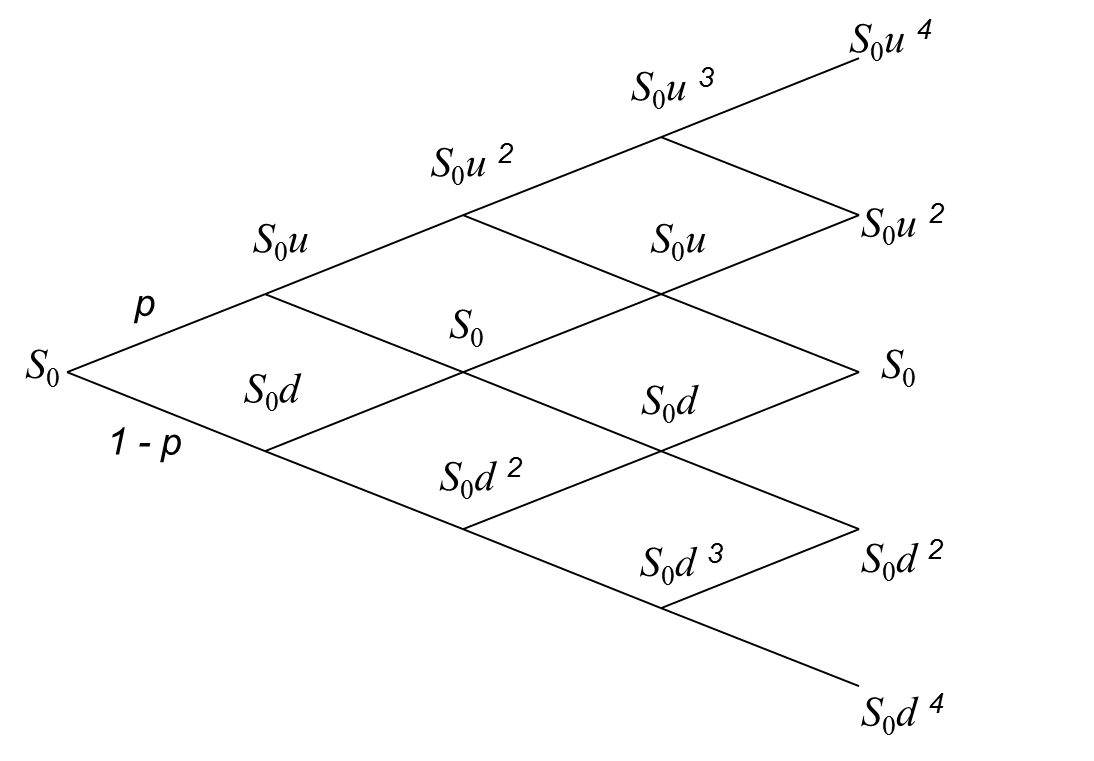

In [6]:
#Binomial model 4 steps, multiplicative 
Step = 4
dt = 1/4  # Number of steps 
u = np.exp(vol * np.sqrt(dt))
d = np.exp(-vol * np.sqrt(dt))
p = (np.exp(r * dt) - d) / (u - d)


option_values = np.zeros(Step + 1)
for x in range(Step + 1):
    S_T = S * u**x * d**(Step - x)  # Asset price at expiry 
    option_values[x] = max(S_T - K, 0)  #Call payoff

#Moving backward to find the price 
for s in reversed(range(Step)):
    for x in range(s + 1):
        option_values[x] = np.exp(-r * dt) * (p * option_values[x + 1] + (1 - p) * option_values[x]) #Assumption of AOA


option_price = option_values[0]

print("Call price is", round(option_price, 4))

Call price is 196.9064
